# Apply Logistic Regression on Amazon fine food reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

Id ProductId - unique identifier for the product UserId - unqiue identifier for the user ProfileName HelpfulnessNumerator - number of users who found the review helpful HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not Score - rating between 1 and 5 Time - timestamp for the review Summary - brief summary of the review Text - text of the review



# [1]. Reading Data

# [1.1] Loading the data

The dataset is available in two forms

.csv file SQLite Database In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [750]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


import os

In [751]:
# using SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-review/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.shape

Number of data points in our data (100000, 10)


(100000, 10)

# [2] Exploratory Data Analysis

# [2.1] Data Cleaning: Deduplication¶


It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [752]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [753]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [754]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [755]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [756]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [757]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

# [3] Preprocessing# 

# [3.1]. Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews



In [758]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'them', 'because', 'again', 'doesn', "hadn't", 'd', 'only', 'o', 'yourselves', 'some', 'by', 'after', 'yours', "haven't", 'while', 'himself', 'yourself', 'before', 'mustn', 'its', 'own', "shan't", 'am', 'my', 'but', 'doing', 'the', 'theirs', 'further', 'hadn', 'with', 'your', 'an', "it's", 'ours', 'above', 'to', 'not', 'you', 'whom', 'other', 'which', 'been', 'being', 'between', 'who', 'few', 's', 'wasn', 'very', "won't", 'over', 'just', 'haven', 'wouldn', 'below', 'this', 'under', "couldn't", "isn't", 'at', 'weren', 'during', 'here', 'all', "mightn't", "she's", 'more', "didn't", 'needn', 'from', 'about', 'our', 'they', "wasn't", 't', "needn't", 'hasn', 'through', 'too', 'is', 'if', 'mightn', "that'll", 'no', 'ourselves', 'she', 'are', 'was', 'it', 'themselves', 'we', 'same', 'his', 'does', 'on', 'nor', 'aren', 'couldn', 'off', 'shouldn', 'in', 'him', 'a', 'out', "shouldn't", 'shan', "you'd", 'down', "wouldn't", 'such', 'of', 'now', 'these', 'have', "aren't", 'won', 'what', "doesn't",

In [759]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1


In [760]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (87773, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infest fruitfli liter everywher fli around kit...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate star...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish read review make purchas basic cardsotck ...


In [761]:
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
time_sorted_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",noth product bother link top page buy use chew...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff doesnt rot gum tast good go buy gum...
61299,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan...",youv never tri kona coffe aloha island definit...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",fresh lime underappreci joy kitchen squirt lim...
38889,42227,B0000A0BS8,A1IU7S4HCK1XK0,Joanna Daneman,5,5,1,1067644800,I gave up on other coffees,The grocery store has all kinds of &quot;gourm...,groceri store kind coffe laid one tri tast lik...
38888,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,1,1067904000,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...,blend one starbuck gentler blend like tast sta...
10992,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,1,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...,chatchi favorit afternoon treat becam mysteri ...


In [762]:
# Getting the Labels i.e the Score out of the dataframe.
y = time_sorted_data['Score']

# Removing the Labels i.e the Score Column from the dataframe as we wont need it to train a KNN.
x = time_sorted_data.drop(columns='Score',inplace=False)
#x.head()
y
x

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",noth product bother link top page buy use chew...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff doesnt rot gum tast good go buy gum...
61299,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan...",youv never tri kona coffe aloha island definit...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",fresh lime underappreci joy kitchen squirt lim...
38889,42227,B0000A0BS8,A1IU7S4HCK1XK0,Joanna Daneman,5,5,1067644800,I gave up on other coffees,The grocery store has all kinds of &quot;gourm...,groceri store kind coffe laid one tri tast lik...
38888,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,1067904000,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...,blend one starbuck gentler blend like tast sta...
10992,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...,chatchi favorit afternoon treat becam mysteri ...


In [763]:
x_train = x.iloc[0:61441]
y_train = y.iloc[0:61441]
x_test =x.iloc[61441:87773]
y_test = y.iloc[61441:87773]
x_test
print ("Training Set - ", x_train.shape)
print ("Test Set - ", x_test.shape)
y_test.shape

Training Set -  (61441, 10)
Test Set -  (26332, 10)


(26332,)

# [4] FEATURIZATION

# 4.1 BAG OF WORDS

In [764]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
bow_train= count_vect.fit_transform(x_train['CleanedText'].values)

bow_train.shape


(61441, 28686)

In [765]:
from sklearn.preprocessing import StandardScaler

train = StandardScaler(with_mean = False).fit_transform(bow_train)
train.shape


(61441, 28686)

In [766]:
bow_test = count_vect.transform(x_test['CleanedText'].values)


bow_test.shape

(26332, 28686)

In [767]:
from sklearn.preprocessing import StandardScaler

test = StandardScaler(with_mean = False).fit_transform(bow_test)
test.shape

(26332, 28686)

In [768]:
list(bow_test.data.shape)

[839667]

# 4.2 TF-IDF

In [769]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_train = tfidf_vect.fit_transform(x_train['CleanedText'].values)
tfidf_train.shape

(61441, 28686)

In [770]:
from sklearn.preprocessing import StandardScaler

train_tfidf = StandardScaler(with_mean = False).fit_transform(tfidf_train)
train_tfidf.shape

(61441, 28686)

In [771]:
tfidf_test = tfidf_vect.transform(x_test['CleanedText'].values)

tfidf_test.shape

(26332, 28686)

In [772]:
from sklearn.preprocessing import StandardScaler

test_tfidf = StandardScaler(with_mean = False).fit_transform(tfidf_test)
test_tfidf.shape


(26332, 28686)

# 4.3 AVERAGE WORD2VEC

In [773]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in x_train['CleanedText'].values:
    list_of_sent.append(sent.split())
    
list_of_test=[]
for sent in x_test['CleanedText'].values:
    list_of_test.append(sent.split())
    

In [774]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [775]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
#print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9898


In [776]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

61441
50


In [777]:
# average Word2Vec
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

26332
50


In [778]:
from sklearn.preprocessing import StandardScaler

train_word = StandardScaler(with_mean = False).fit_transform(sent_vectors)
print(len(train_word))
train_word.shape

61441


(61441, 50)

In [779]:
from sklearn.preprocessing import StandardScaler

test_word = StandardScaler(with_mean = False).fit_transform(test_vectors)
print(len(test_word))

26332


# APPLYING LOGISTIC REGRESSION

# [5.1] Logistic Regression on BOW, SET 1¶


# [5.1.1] Applying Logistic Regression with L2 regularization on BOW, SET 1

In [780]:
# Importing libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Importing libraries for accuracy metrics
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve,auc

In [781]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
#print("Auc  of the model : ",model.score(test, y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The optimal value of C(1/lambda) is :  0.01


In [782]:
cv_scores  = model.cv_results_['mean_test_score']
train_scores  = model.cv_results_['mean_train_score']

train_scores

array([0.97437291, 0.99768953, 0.99965491, 0.99946274, 0.99979652])

# Plotting auc for training and test

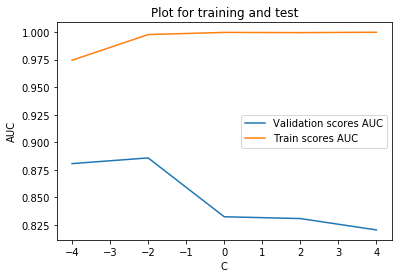

In [783]:
import math
plt.plot(np.log10(tuned_parameters[0]['C']),cv_scores,label="Validation scores AUC")
plt.plot(np.log10(tuned_parameters[0]['C']),train_scores,label="Train scores AUC")

plt.ylabel('AUC')
plt.xlabel('C')
plt.title('Plot for training and test')
plt.legend()
plt.show()

In [784]:
best_c = model.best_params_['C']
AUC_BW_L2 = model.best_score_
print("Best hyper parameter to use is",best_c)
print(AUC_BW_L2)

Best hyper parameter to use is 0.01
0.8858100333789197


In [785]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
from sklearn.metrics import roc_auc_score
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=1)
lr.fit(train,y_train)

predictions=lr.predict(test)

predictions1=lr.predict_proba(test)
predictions1_train=lr.predict_proba(train)

In [786]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
auc_final = roc_auc_score(y_test,predictions1[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predictions1[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train,predictions1_train[:,1])
print(auc_final)

0.8890715259475148


# Plotting roc for training and test data

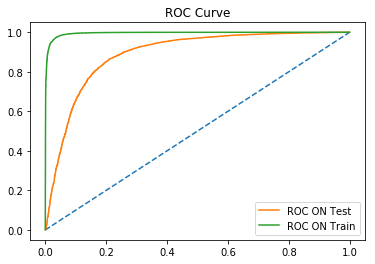

In [787]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr,label="ROC ON Test")
plt.plot(fpr_tr, tpr_tr,label="ROC ON Train")
plt.title('ROC Curve')
plt.legend()
plt.show()

# PLOTTING CONFUSION MAYTRIX

[[2830, 1727], [1115, 20660]]


,Predicted No,Predicted Yes
Actual No,2830,1727
Actual Yes,1115,20660


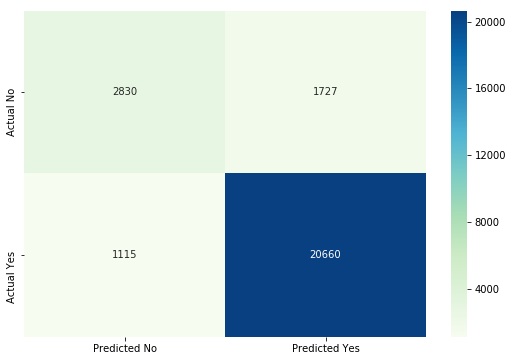

In [788]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[round(tn), round(fp)], [round(fn), round(tp)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# MULTICOLLINEARITY CHECK(PERTUBATION TECHNIQUE)

In [789]:
weights_before=lr.coef_
weights_before

array([[ 5.86104441e-05,  6.12916466e-04, -2.19840998e-08, ...,
         6.91909952e-05,  1.19157628e-02,  3.35914562e-03]])

In [790]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_


no_of_non_zero = train.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of train
indices_X_train = train.indices
indptr_X_train = train.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = train.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and train to get a new sparse matrix with epsilon added to each 
# non-zero element of train
epsilon_train = train + sparse_epsilon

print(train.shape)
print(epsilon_train.shape)


(61441, 28686)
(61441, 28686)


In [791]:
# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=1)
epsilon_lr.fit(epsilon_train,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [792]:
# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_
print(W_after_epsilon)

[[ 5.85925061e-05  6.12696637e-04 -7.00478814e-09 ...  6.92125129e-05
   1.19155843e-02  3.35900932e-03]]


In [793]:
W_before_epsilon = W_before_epsilon + 10**-6
W_after_epsilon =W_after_epsilon  + 10**-6
W_before_epsilon

array([[5.96104441e-05, 6.13916466e-04, 9.78015900e-07, ...,
        7.01909952e-05, 1.19167628e-02, 3.36014562e-03]])

In [794]:
change = abs(((W_before_epsilon-W_after_epsilon)/W_before_epsilon))*100

In [795]:
change

array([[3.00921494e-02, 3.58075436e-02, 1.53160206e+00, ...,
        3.06559447e-02, 1.49713076e-03, 4.05643350e-03]])

In [796]:
K=change.ravel()
K

array([3.00921494e-02, 3.58075436e-02, 1.53160206e+00, ...,
       3.06559447e-02, 1.49713076e-03, 4.05643350e-03])

# Sorting change in weight vectors in descending order

In [797]:
Y=np.sort(k)
Y
Z=Y[::-1]
Z


array([1.27609103e+06, 1.27609103e+06, 1.27609103e+06, ...,
       1.35186446e-06, 6.97949058e-07, 8.74094210e-08])

# Calculating percentile

In [798]:
for i in np.arange(0, 101, 1):
    print(i)
    print(np.percentile(list(Z),i))

0
8.740942096526808e-08
1
0.00016979391395367807
2
0.0003442309942304296
3
0.00052180814280301
4
0.0007006062535015506
5
0.0008893769419567456
6
0.0010756293317370803
7
0.0012665447778474228
8
0.001447119261909729
9
0.0016241505516730332
10
0.001807451896763805
11
0.002007603185363997
12
0.0022034875523501782
13
0.0024058459426183607
14
0.0026216588931791086
15
0.0028283423292062054
16
0.0030139165848751042
17
0.0032313851023695918
18
0.003428838751949926
19
0.003670420687033447
20
0.0039047571084780317
21
0.004128662476300837
22
0.004351809716584037
23
0.004552726552502247
24
0.004787484170599904
25
0.00502015007394754
26
0.005241332768876176
27
0.00548433123866985
28
0.005739918007507501
29
0.006002951559408141
30
0.006272528102700459
31
0.006563068595599112
32
0.006832843862541517
33
0.00712268602102014
34
0.007438267782697428
35
0.007752364557904528
36
0.008059850858793627
37
0.008425713098857292
38
0.008817376699179742
39
0.00916729032233361
40
0.009576635273306777
41
0.0099670217

so this indicates that our threshold value lie betweem 99 and 100 percentile

In [799]:
for i in np.arange(99,100.1,0.1):
    print(i)
    print(np.percentile(list(Z),i))


99.0
105.42363793447838
99.1
114.41615052694567
99.19999999999999
125.3707637045612
99.29999999999998
155.84528860684296
99.39999999999998
176.52149721199893
99.49999999999997
218.15942832316838
99.59999999999997
313.16538341267756
99.69999999999996
444.5526878597802
99.79999999999995
868.9367868410168
99.89999999999995
4125.8357479285505
99.99999999999994
1276091.0315998376


So here we can set threshold value as 99.8 percentile

Getting values in a list where percentage change is more than 4125

In [801]:
lst_c = list(filter(lambda x: x>4125,Z))
len(lst_c)

32

# printing all collinear features

In [802]:
M=np.argsort(k)[::-1]
collinear_fatures = np.take(count_vect.get_feature_names(),M[:32])
print("***********************Below features are collinear*****************************")
print(collinear_fatures)


***********************Below features are collinear*****************************
['çaykur' 'zuma' 'zowi' 'zreport' 'zsweet' 'zucchini' 'zuccini' 'zuchinni'
 'zuchon' 'zuke' 'zukess' 'zzzzzzzzzzz' 'zulu' 'zupa' 'zuppa' 'zwieback'
 'zyliss' 'zylitol' 'zymox' 'zyto' 'zzzzzs' 'zzzzzzz' 'zzzzzzzzzz' 'zout'
 'zotz' 'zoonot' 'zoomi' 'zoom' 'zoo' 'zon' 'zombi' 'zone']


# Here we are getting top 20 features for feature importance

In [803]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))


Top 20 features with their weight values :
       great	--> 	0.811764
        love	--> 	0.609336
        best	--> 	0.571894
        good	--> 	0.512647
      delici	--> 	0.512210
     perfect	--> 	0.446357
        nice	--> 	0.425518
       excel	--> 	0.402077
     favorit	--> 	0.361244
  disappoint	--> 	-0.353012
      wonder	--> 	0.289235
       tasti	--> 	0.287224
     terribl	--> 	-0.281437
       worst	--> 	-0.270529
       thank	--> 	0.266491
        easi	--> 	0.264498
       yummi	--> 	0.263028
     horribl	--> 	-0.262374
          aw	--> 	-0.261640
       snack	--> 	0.259491


# TOP 20 FEATURES FOR NEGATIVE CLASS

In [804]:
S=lr.coef_.ravel().argsort()
M=lr.coef_.ravel()[S]
X=M[0:20]
feature_names=np.array(count_vect.get_feature_names())
L=feature_names[S]
L
Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O


,features,score
0,disappoint,-0.353012
1,terribl,-0.281437
2,worst,-0.270529
3,horribl,-0.262374
4,aw,-0.261640
5,tast,-0.250003
6,return,-0.237287
7,unfortun,-0.231484
8,bland,-0.224549
9,bad,-0.211959


# TOP 20 IMPORTANT FEATURES FOR POSITIVE CLASS

In [805]:
S=lr.coef_.ravel().argsort()[::-1]
M=lr.coef_.ravel()[S]
X=M[0:20]
feature_names=np.array(count_vect.get_feature_names())
L=feature_names[S]

Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O


,features,score
0,great,0.811764
1,love,0.609336
2,best,0.571894
3,good,0.512647
4,delici,0.512210
5,perfect,0.446357
6,nice,0.425518
7,excel,0.402077
8,favorit,0.361244
9,wonder,0.289235


# Plotting the percentage change plot

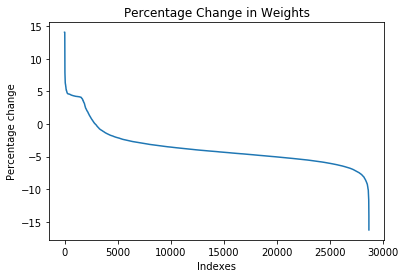

In [806]:
plt.plot( np.arange(0,len(Z)),np.log(Z))
# plot the roc curve for the model

plt.xlabel('Indexes')
plt.ylabel('Percentage change')
plt.title('Percentage Change in Weights')

plt.show()


# [5.1.2] Applying Logistic Regression with L1 regularization on BOW, SET 1

In [807]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
#print("Auc  of the model : ",model.score(test, y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The optimal value of C(1/lambda) is :  0.01


In [808]:
cv_scores  = model.cv_results_['mean_test_score']
train_scores  = model.cv_results_['mean_train_score']

cv_scores

array([0.5       , 0.92389455, 0.85293602, 0.80032153, 0.79027937])

# Plotting AUC score for train and cross validation data¶


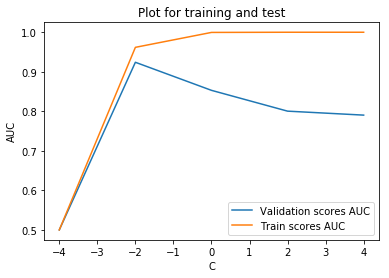

In [809]:
import math
plt.plot(np.log10(tuned_parameters[0]['C']),cv_scores,label="Validation scores AUC")
plt.plot(np.log10(tuned_parameters[0]['C']),train_scores,label="Train scores AUC")

plt.ylabel('AUC')
plt.xlabel('C')
plt.title('Plot for training and test')
plt.legend()
plt.show()

In [810]:
best_c = model.best_params_['C']
AUC_BW_L1 = model.best_score_
print("Best hyper parameter to use is",best_c)
print(AUC_BW_L1)

Best hyper parameter to use is 0.01
0.9238945491100307


In [811]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
from sklearn.metrics import roc_auc_score
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=1)
lr.fit(train,y_train)

predictions=lr.predict(test)

predictions1=lr.predict_proba(test)
predictions1_train=lr.predict_proba(train)

In [812]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
auc_final = roc_auc_score(y_test,predictions1[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predictions1[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train,predictions1_train[:,1])
print(auc_final)

0.9338590986929938


# Plotting roc for trainanad test

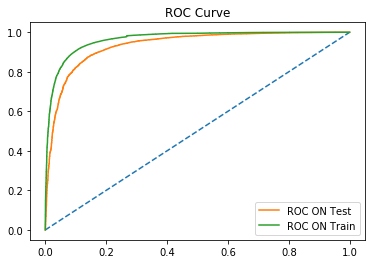

In [813]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr,label="ROC ON Test")
plt.plot(fpr_tr, tpr_tr,label="ROC ON Train")
plt.title('ROC Curve')
plt.legend()
plt.show()

# plotting confusion nmatrix

[[2447, 2110], [441, 21334]]


,Predicted No,Predicted Yes
Actual No,2447,2110
Actual Yes,441,21334


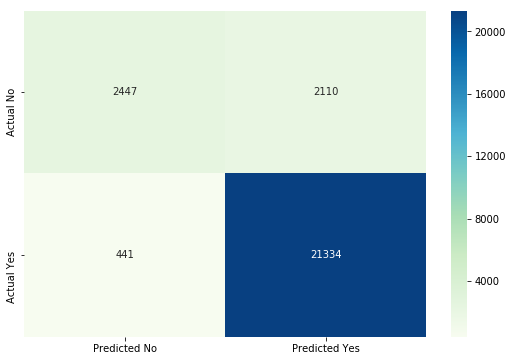

In [814]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[round(tn), round(fp)], [round(fn), round(tp)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# calculate sparsity for l1 regularization

In [815]:
non_zero = np.count_nonzero(lr.coef_)
sparsity = (np.size(lr.coef_) - non_zero) / np.size(lr.coef_)
print("Sparsity using L1 regularization :",sparsity)


Sparsity using L1 regularization : 0.8902600571707453


In [816]:
np.size(lr.coef_)

28686

# Top 20 important features for positive  class

In [817]:
S=lr.coef_.ravel().argsort()[::-1]
M=lr.coef_.ravel()[S]
X=M[0:20]
feature_names=np.array(count_vect.get_feature_names())
L=feature_names[S]

Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O


,features,score
0,great,0.615072
1,best,0.441295
2,love,0.426513
3,delici,0.410000
4,perfect,0.340672
5,good,0.334068
6,excel,0.300043
7,nice,0.261640
8,favorit,0.225945
9,amaz,0.211281


# Top 20 important featues for negative class

In [818]:
S=lr.coef_.ravel().argsort()
M=lr.coef_.ravel()[S]
X=M[0:20]
feature_names=np.array(count_vect.get_feature_names())
L=feature_names[S]
L
Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O


,features,score
0,disappoint,-0.294068
1,worst,-0.207876
2,tast,-0.176852
3,aw,-0.172211
4,bad,-0.171944
5,terribl,-0.166026
6,horribl,-0.146267
7,return,-0.145807
8,product,-0.143234
9,thought,-0.139349


# [5.2] Logistic Regression on TFIDF, SET 2

# [5.2.1] Applying Logistic Regression with L2 regularization on TFIDF, SET 2

In [819]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(train_tfidf, y_train)
print("Model with best parameters :\n",model.best_estimator_)
#print("Auc  of the model : ",model.score(test, y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The optimal value of C(1/lambda) is :  0.0001


In [820]:
cv_scores  = model.cv_results_['mean_test_score']
train_scores  = model.cv_results_['mean_train_score']
cv_scores

array([0.91624088, 0.88430952, 0.8296041 , 0.82049442, 0.82003808])

# plotting auc for train and test

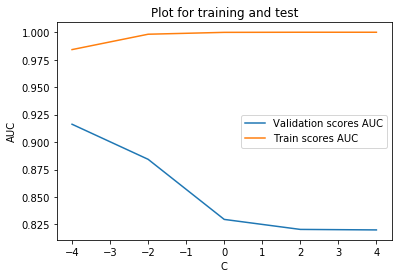

In [821]:
import math
plt.plot(np.log10(tuned_parameters[0]['C']),cv_scores,label="Validation scores AUC")
plt.plot(np.log10(tuned_parameters[0]['C']),train_scores,label="Train scores AUC")

plt.ylabel('AUC')
plt.xlabel('C')
plt.title('Plot for training and test')
plt.legend()
plt.show()

In [822]:
best_c = model.best_params_['C']
AUC_BW_L1 = model.best_score_
print("Best hyper parameter to use is",best_c)
print(AUC_BW_L1)

Best hyper parameter to use is 0.0001
0.9162408835690445


In [823]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
from sklearn.metrics import roc_auc_score
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=1)
lr.fit(train_tfidf,y_train)

predictions=lr.predict(test_tfidf)

predictions1=lr.predict_proba(test_tfidf)
predictions1_train=lr.predict_proba(train_tfidf)

In [824]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
auc_final = roc_auc_score(y_test,predictions1[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predictions1[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train,predictions1_train[:,1])
print(auc_final)

0.9234539008003483


# Plotting roc for train and test data

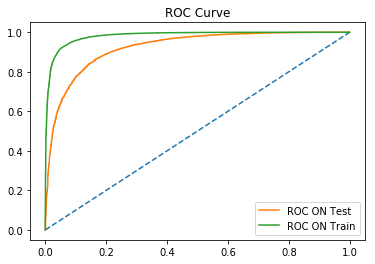

In [825]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr,label="ROC ON Test")
plt.plot(fpr_tr, tpr_tr,label="ROC ON Train")
plt.title('ROC Curve')
plt.legend()
plt.show()

[[1892, 2665], [243, 21532]]


,Predicted No,Predicted Yes
Actual No,1892,2665
Actual Yes,243,21532


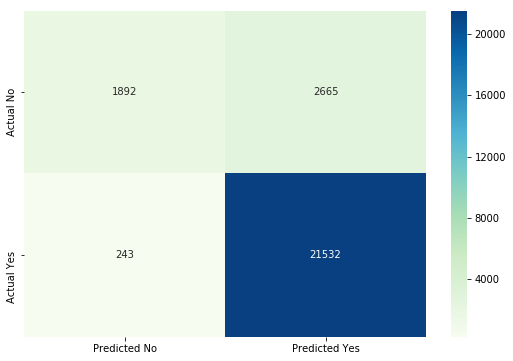

In [826]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[(tn), (fp)], [(fn), (tp)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# Top 20 important features for positive class

In [827]:
S=lr.coef_.ravel().argsort()[::-1]
M=lr.coef_.ravel()[S]
X=M[0:20]
feature_names=np.array(tfidf_vect.get_feature_names())
L=feature_names[S]

Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O


,features,score
0,great,0.162701
1,love,0.146074
2,good,0.112829
3,best,0.109247
4,delici,0.093896
5,perfect,0.080236
6,nice,0.075997
7,favorit,0.075730
8,excel,0.072112
9,find,0.067124


# Top 20 features for negative class

In [828]:
S=lr.coef_.ravel().argsort()
M=lr.coef_.ravel()[S]
X=M[0:20]
feature_names=np.array(tfidf_vect.get_feature_names())
L=feature_names[S]
L
Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O


,features,score
0,disappoint,-0.097098
1,worst,-0.071887
2,terribl,-0.066770
3,return,-0.066035
4,horribl,-0.064432
5,aw,-0.063839
6,wast,-0.062146
7,bad,-0.061029
8,threw,-0.055176
9,unfortun,-0.051669


# [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF, SET 2

In [829]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(train_tfidf, y_train)
print("Model with best parameters :\n",model.best_estimator_)
#print("Auc  of the model : ",model.score(test, y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The optimal value of C(1/lambda) is :  0.01


In [830]:
cv_scores  = model.cv_results_['mean_test_score']
train_scores  = model.cv_results_['mean_train_score']

train_scores

array([0.5       , 0.96722268, 0.99961997, 1.        , 1.        ])

# plotting auc score for train and test

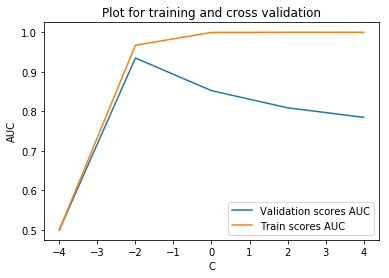

In [831]:
import math
plt.plot(np.log10(tuned_parameters[0]['C']),cv_scores,label="Validation scores AUC")
plt.plot(np.log10(tuned_parameters[0]['C']),train_scores,label="Train scores AUC")

plt.ylabel('AUC')
plt.xlabel('C')
plt.title('Plot for training and cross validation')
plt.legend()
plt.show()

In [832]:
best_c = model.best_params_['C']
AUC_BW_L1 = model.best_score_
print("Best hyper parameter to use is",best_c)
print(AUC_BW_L1)

Best hyper parameter to use is 0.01
0.9348229555673996


In [833]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
from sklearn.metrics import roc_auc_score
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=1)
lr.fit(train_tfidf,y_train)

predictions=lr.predict(test_tfidf)

predictions1=lr.predict_proba(test_tfidf)
predictions1_train=lr.predict_proba(train_tfidf)

In [834]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
auc_final = roc_auc_score(y_test,predictions1[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predictions1[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train,predictions1_train[:,1])
print(auc_final)

0.9438251795662896


# plotting roc for train and test data

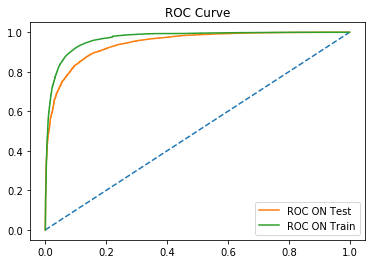

In [835]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr,label="ROC ON Test")
plt.plot(fpr_tr, tpr_tr,label="ROC ON Train")
plt.title('ROC Curve')
plt.legend()
plt.show()

# plotting confusion matrix

[[2574, 1983], [418, 21357]]


,Predicted No,Predicted Yes
Actual No,2574,1983
Actual Yes,418,21357


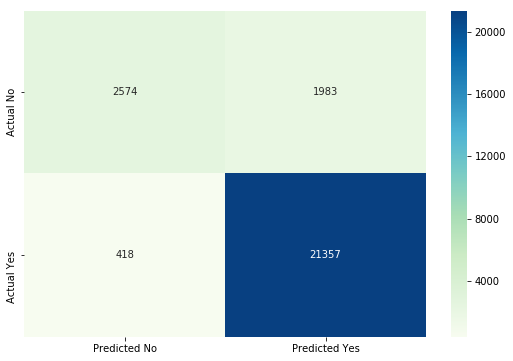

In [836]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[round(tn), round(fp)], [round(fn), round(tp)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# TOP 20 IMPORTANT FEATURES FOR POSITIVE CLASS

In [837]:
S=lr.coef_.ravel().argsort()[::-1]
M=lr.coef_.ravel()[S]
X=M[0:20]
feature_names=np.array(tfidf_vect.get_feature_names())
L=feature_names[S]

Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O


,features,score
0,great,0.680430
1,love,0.472710
2,best,0.461324
3,delici,0.433631
4,perfect,0.350732
5,good,0.347543
6,excel,0.307271
7,nice,0.275042
8,favorit,0.227250
9,amaz,0.223797


# Top 20 important features for negative class

In [838]:
S=lr.coef_.ravel().argsort()
M=lr.coef_.ravel()[S]
X=M[0:20]
feature_names=np.array(tfidf_vect.get_feature_names())
L=feature_names[S]
L
Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O

,features,score
0,disappoint,-0.256131
1,worst,-0.208245
2,tast,-0.165106
3,aw,-0.162310
4,terribl,-0.157131
5,return,-0.147764
6,horribl,-0.140970
7,bad,-0.140154
8,product,-0.131146
9,threw,-0.127372


# [5.3] logistic regression on word2vec

# 5.3.1 Applying Logistic regression for L2 regularization using word2vec set3

In [839]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(train_word, y_train)
print("Model with best parameters :\n",model.best_estimator_)
#print("Auc  of the model : ",model.score(test, y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The optimal value of C(1/lambda) is :  100


In [848]:
cv_scores  = model.cv_results_['mean_test_score']
train_scores  = model.cv_results_['mean_train_score']


cv_scores

array([0.87768915, 0.9006707 , 0.9007004 , 0.90070137, 0.90070127])

# Plotting auc for train and test

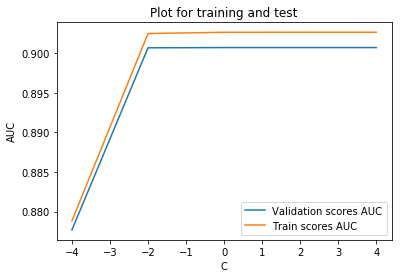

In [841]:
import math
plt.plot(np.log10(tuned_parameters[0]['C']),cv_scores,label="Validation scores AUC")
plt.plot(np.log10(tuned_parameters[0]['C']),train_scores,label="Train scores AUC")

plt.ylabel('AUC')
plt.xlabel('C')
plt.title('Plot for training and test')
plt.legend()
plt.show()

In [842]:
best_c = model.best_params_['C']
AUC_word_L2 = model.best_score_
print("Best hyper parameter to use is",best_c)
print(AUC_word_L2)

Best hyper parameter to use is 100
0.9007013723042905


In [843]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
from sklearn.metrics import roc_auc_score
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=1)
lr.fit(train_word,y_train)

predictions=lr.predict(test_word)

predictions1=lr.predict_proba(test_word)
predictions1_train=lr.predict_proba(train_word)

In [844]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
auc_final = roc_auc_score(y_test,predictions1[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predictions1[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train,predictions1_train[:,1])
print(auc_final)

0.9017646159237741


# Plotting roc for train and test

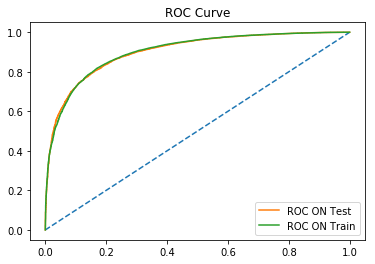

In [845]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr,label="ROC ON Test")
plt.plot(fpr_tr, tpr_tr,label="ROC ON Train")
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plotting confusion matrix

[[2173, 2384], [776, 20999]]


,Predicted No,Predicted Yes
Actual No,2173,2384
Actual Yes,776,20999


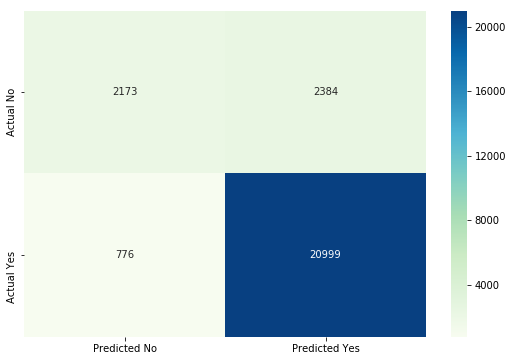

In [849]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[round(tn), round(fp)], [round(fn), round(tp)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# 5.3.2 APPLYING LOGISTIC REGRESSION FOR L1 REGULARIZATION USING WORD2VEC SET3

In [850]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(train_word, y_train)
print("Model with best parameters :\n",model.best_estimator_)
#print("Auc  of the model : ",model.score(test, y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The optimal value of C(1/lambda) is :  10000


In [854]:
cv_scores  = model.cv_results_['mean_test_score']
train_scores  = model.cv_results_['mean_train_score']
cv_scores

array([0.57370258, 0.89909523, 0.9006844 , 0.90069822, 0.90070055])

# Plotting auc for train and cross validation

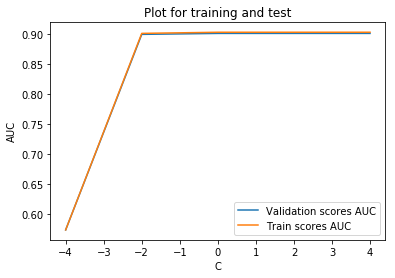

In [852]:
import math
plt.plot(np.log10(tuned_parameters[0]['C']),cv_scores,label="Validation scores AUC")
plt.plot(np.log10(tuned_parameters[0]['C']),train_scores,label="Train scores AUC")

plt.ylabel('AUC')
plt.xlabel('C')
plt.title('Plot for training and test')
plt.legend()
plt.show()

In [855]:
best_c = model.best_params_['C']
AUC_BW_L1 = model.best_score_
print("Best hyper parameter to use is",best_c)
print(AUC_BW_L1)

Best hyper parameter to use is 10000
0.9007005541947242


In [856]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
from sklearn.metrics import roc_auc_score
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=1)
lr.fit(train_word,y_train)

predictions=lr.predict(test_word)

predictions1=lr.predict_proba(test_word)
predictions1_train=lr.predict_proba(train_word)

In [857]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
auc_final = roc_auc_score(y_test,predictions1[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predictions1[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train,predictions1_train[:,1])
print(auc_final)

0.9018059648584442


# PLOTTING ROC

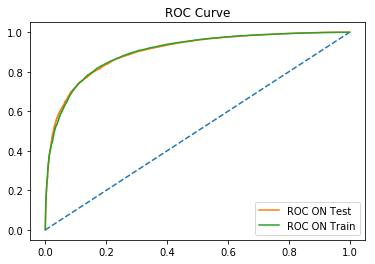

In [858]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr,label="ROC ON Test")
plt.plot(fpr_tr, tpr_tr,label="ROC ON Train")
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plotting confusion matrix

[[2185, 2372], [783, 20992]]


,Predicted No,Predicted Yes
Actual No,2185,2372
Actual Yes,783,20992


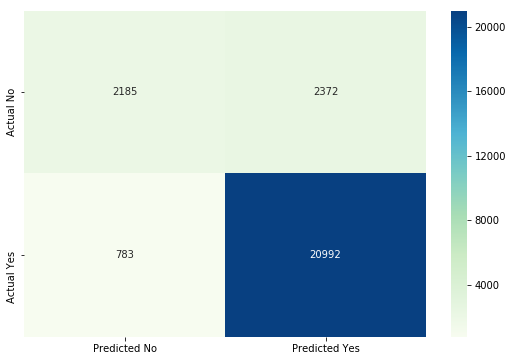

In [859]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[(tn),(fp)], [(fn), (tp)]]
print(array)
df_cm = pd.DataFrame(array, ['Actual No','Actual Yes'],
                  ['Predicted No','Predicted Yes'])
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True,fmt='d', cmap = "GnBu")
df_cm

# FINAL TABLE

In [3]:
from prettytable import PrettyTable

    
x = PrettyTable()

x.field_names = ["Vectorizer", "Regularization", "Optimal_C", "AUC"]

x.add_row(["BOW", "L2", 0.01,0.889])
x.add_row(["BOW", "L1", 0.01,0.933])
x.add_row(["TF-IDF","L2", 0.0001,0.9233])
x.add_row(["TF-IDF","L1", 0.01,0.943])
x.add_row(["WORD2VEC","L2", 100,0.901])
x.add_row(["WORD2VEC","L1", 10000,0.901])
print(x)


+------------+----------------+-----------+--------+
| Vectorizer | Regularization | Optimal_C |  AUC   |
+------------+----------------+-----------+--------+
|    BOW     |       L2       |    0.01   | 0.889  |
|    BOW     |       L1       |    0.01   | 0.933  |
|   TF-IDF   |       L2       |   0.0001  | 0.9233 |
|   TF-IDF   |       L1       |    0.01   | 0.943  |
|  WORD2VEC  |       L2       |    100    | 0.901  |
|  WORD2VEC  |       L1       |   10000   | 0.901  |
+------------+----------------+-----------+--------+


In [864]:
pip install prettytable


The following command must be run outside of the IPython shell:

    $ pip install prettytable

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/
